# Character Language Modelling On 'Sing a Song of Sixpence'

<p style="text-align:center;"><a href="https://commons.wikimedia.org/wiki/File:SingSong6dcaldecott.jpg#/media/File:SingSong6dcaldecott.jpg"><img src="https://upload.wikimedia.org/wikipedia/commons/6/66/SingSong6dcaldecott.jpg" alt="SingSong6dcaldecott.jpg"></a></p><br>

Cover illustration for Randolph Caldecott's Sing a Song for Sixpence (1880)

> **A language model predicts the next word in the sequence based on the specific words that have come before it in the sequence. It is also possible to develop language models at the charact level using neural networks. The benefit of character-based language models is their small vocabulary and flexibility in handling any words, punctuation, and other document structure. This comes at the cost of requiring larger models that are slower to train.**

## Importing required libraries

In [1]:
import re, string, pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import keras_tuner
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

## Creating a function to load the text into the memory

In [2]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [3]:
print(load_doc('/kaggle/input/sing-a-song-of-sixpence/rhyme.txt'))

﻿
                        Sing a Song of Sixpence.

A brand new sixpence fresh from the Mint!  How it sparkled and glittered
in the dancing sunlight!  Such a treasure for a small girl to possess!
But then, on the other hand, what a heavy responsibility!

All day long it had been burning a hole in her pocket, and as for
learning lessons, not an idea would enter her head.  Everything went in
at one ear and out of the other, as Miss Primmer sternly remarked when
Nellie could not say her poetry.  But, indeed, Nellie _did_ try hard to
learn her lessons; she squeezed her eyes together as tightly as
possible, though how shutting her eyes was to prevent the lessons from
coming out of her ears was not very clear.  "But _I must_ learn them
now," she sighed, "or Miss Primmer will keep me in to-morrow, and I
shan’t be able to go out with Nursie and Reggie to spend my sixpence.
Oh dear!  I wish I could learn my poetry and keep it in, I guess I’d
better get a bit of cotton wool to put in my ears and

## Creating a function to clean the text

In [4]:
def clean_text(text):
    
    ## splitting the text using the whitespace
    tokens = text.split()
    
    ## lowering the case of tokens
    tokens = [token.lower() for token in tokens]
    
    ## joining all the tokens together by whitespace
    text = ' '.join(tokens)
    
    return text

## Cleaning the text using created function

In [5]:
filename = '/kaggle/input/sing-a-song-of-sixpence/rhyme.txt'
text = load_doc(filename)
cleaned_text = clean_text(text)

In [6]:
cleaned_text

'\ufeff sing a song of sixpence. a brand new sixpence fresh from the mint! how it sparkled and glittered in the dancing sunlight! such a treasure for a small girl to possess! but then, on the other hand, what a heavy responsibility! all day long it had been burning a hole in her pocket, and as for learning lessons, not an idea would enter her head. everything went in at one ear and out of the other, as miss primmer sternly remarked when nellie could not say her poetry. but, indeed, nellie _did_ try hard to learn her lessons; she squeezed her eyes together as tightly as possible, though how shutting her eyes was to prevent the lessons from coming out of her ears was not very clear. "but _i must_ learn them now," she sighed, "or miss primmer will keep me in to-morrow, and i shan’t be able to go out with nursie and reggie to spend my sixpence. oh dear! i wish i could learn my poetry and keep it in, i guess i’d better get a bit of cotton wool to put in my ears and then it _can’t_ come out.

## Let's create input-output sequence to train the model (The sequence will be of 10 characters for input and 1 character for output)

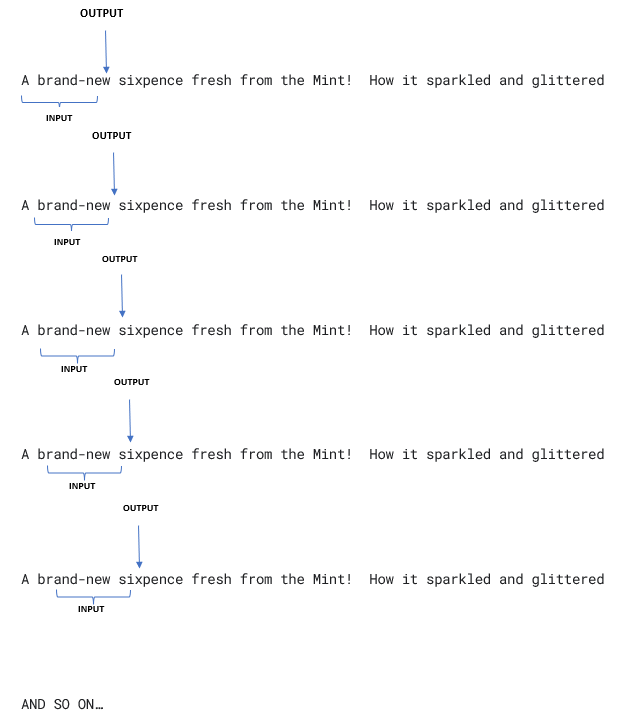

**Note that for each iteration, we are taking 10 characters as input and the 11th chracter as output. And everytime we are sliding this 11 chracter window by 1 charcter to the right side. Also note that in the text whitespace is also considered as one of the character.**

In [7]:
length = 10
sequences = list()
for i in range(length,len(cleaned_text)):
    seq = cleaned_text[i-length: i+1]
    sequences.append(seq)
print(f"Total sequences: {len(sequences)}")

Total sequences: 32743


## let's save the created sequences to a text file so that we can load it later using a function

In [8]:
def save_doc(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()
    
filename = '/kaggle/working/sequences.txt'
save_doc(sequences, filename)

## Now, let's load the sequences to encode them before feeding to the model

In [9]:
seq_filename = '/kaggle/working/sequences.txt'
raw_text = load_doc(seq_filename)
lines = raw_text.split('\n')

## Check out the newly created input and output character sets

In [10]:
print(lines)

['\ufeff sing a so', ' sing a son', 'sing a song', 'ing a song ', 'ng a song o', 'g a song of', ' a song of ', 'a song of s', ' song of si', 'song of six', 'ong of sixp', 'ng of sixpe', 'g of sixpen', ' of sixpenc', 'of sixpence', 'f sixpence.', ' sixpence. ', 'sixpence. a', 'ixpence. a ', 'xpence. a b', 'pence. a br', 'ence. a bra', 'nce. a bran', 'ce. a brand', 'e. a brand ', '. a brand n', ' a brand ne', 'a brand new', ' brand new ', 'brand new s', 'rand new si', 'and new six', 'nd new sixp', 'd new sixpe', ' new sixpen', 'new sixpenc', 'ew sixpence', 'w sixpence ', ' sixpence f', 'sixpence fr', 'ixpence fre', 'xpence fres', 'pence fresh', 'ence fresh ', 'nce fresh f', 'ce fresh fr', 'e fresh fro', ' fresh from', 'fresh from ', 'resh from t', 'esh from th', 'sh from the', 'h from the ', ' from the m', 'from the mi', 'rom the min', 'om the mint', 'm the mint!', ' the mint! ', 'the mint! h', 'he mint! ho', 'e mint! how', ' mint! how ', 'mint! how i', 'int! how it', 'nt! how it ', 't! 

## Encoding characters using integers

**The sequence of characters must be encoded as integers. This means that each unique character will be assigned a specific integer value and each sequence 
of characters will be encoded as a sequence of integers.**

**1. Creating a mapping between chracter and an integer**

In [11]:
chars = sorted(list(set(raw_text)))

mapping = dict((character, index) for index, character in enumerate(chars))

print(mapping)

{'\n': 0, ' ': 1, '!': 2, '"': 3, ',': 4, '-': 5, '.': 6, ':': 7, ';': 8, '?': 9, '[': 10, ']': 11, '_': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'k': 23, 'l': 24, 'm': 25, 'n': 26, 'o': 27, 'p': 28, 'q': 29, 'r': 30, 's': 31, 't': 32, 'u': 33, 'v': 34, 'w': 35, 'x': 36, 'y': 37, 'z': 38, '’': 39, '\ufeff': 40}


**2. Replacing the characters with their respective integer from mapping**

In [12]:
## now, encoding the sequence of characters using the above created mapping

sequences = list()
for line in lines:
    encoded_seq = [mapping[character] for character in line]
    sequences.append(encoded_seq)

## Checking out the encoded sequences

In [13]:
sequences

[[40, 1, 31, 21, 26, 19, 1, 13, 1, 31, 27],
 [1, 31, 21, 26, 19, 1, 13, 1, 31, 27, 26],
 [31, 21, 26, 19, 1, 13, 1, 31, 27, 26, 19],
 [21, 26, 19, 1, 13, 1, 31, 27, 26, 19, 1],
 [26, 19, 1, 13, 1, 31, 27, 26, 19, 1, 27],
 [19, 1, 13, 1, 31, 27, 26, 19, 1, 27, 18],
 [1, 13, 1, 31, 27, 26, 19, 1, 27, 18, 1],
 [13, 1, 31, 27, 26, 19, 1, 27, 18, 1, 31],
 [1, 31, 27, 26, 19, 1, 27, 18, 1, 31, 21],
 [31, 27, 26, 19, 1, 27, 18, 1, 31, 21, 36],
 [27, 26, 19, 1, 27, 18, 1, 31, 21, 36, 28],
 [26, 19, 1, 27, 18, 1, 31, 21, 36, 28, 17],
 [19, 1, 27, 18, 1, 31, 21, 36, 28, 17, 26],
 [1, 27, 18, 1, 31, 21, 36, 28, 17, 26, 15],
 [27, 18, 1, 31, 21, 36, 28, 17, 26, 15, 17],
 [18, 1, 31, 21, 36, 28, 17, 26, 15, 17, 6],
 [1, 31, 21, 36, 28, 17, 26, 15, 17, 6, 1],
 [31, 21, 36, 28, 17, 26, 15, 17, 6, 1, 13],
 [21, 36, 28, 17, 26, 15, 17, 6, 1, 13, 1],
 [36, 28, 17, 26, 15, 17, 6, 1, 13, 1, 14],
 [28, 17, 26, 15, 17, 6, 1, 13, 1, 14, 30],
 [17, 26, 15, 17, 6, 1, 13, 1, 14, 30, 13],
 [26, 15, 17, 6, 1, 13,

## finding the vocab size using a mapping

In [14]:
vocab_size = len(mapping)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 41


## Let's split the encoded data into input and output data

In [15]:
sequences = np.array(sequences)
X, y = sequences[:, :-1], sequences[:, -1]

## one-hot encoding the input and output data

In [16]:
X_onehot = [to_categorical(x, num_classes=vocab_size) for x in X]
X = np.array(X_onehot)
y = to_categorical(y, num_classes=vocab_size)

In [17]:
X.shape

(32743, 10, 41)

In [18]:
y.shape

(32743, 41)

## Splitting the data into training data and the validation data

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=23)

> * **In Artifical Neural Networks (ANN), input is of shape (N,D), where N is the number of samples and D is the number of features.**
> * **IN RNN, GRU and LSTM, input is of shape (N,T,D), where N is the number of samples, T is length of time sequence and D is the number of features.**
> 
> * **So, while adding layers, Input(shape = (D,)) for ANN and Input(shape = (T,D)) for RNN, GRU and LSTMs**

## Let's create a model (Using different learning rate schedulers)

In [20]:
def build_model(hp):
    units = hp.Int('units', min_value=32, max_value=512, step=32)
    activation = hp.Choice('activation', ['relu','selu','elu'])
    dropout = hp.Boolean('dropout')
    lr = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    
    model = call_existing_code(units=units, activation=activation, dropout=dropout, lr=lr)
    return model

In [21]:
def call_existing_code(units, activation, dropout,lr):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=units, return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
    if dropout:
        model.add(Dropout(rate=0.25))
    model.add(Bidirectional(LSTM(units=units)))
    if dropout:
        model.add(Dropout(rate=0.25))
    model.add(Dense(units=units, activation=activation))
    model.add(Dense(vocab_size, activation='softmax'))
    
    model.compile(optimizer= Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [22]:
build_model(keras_tuner.HyperParameters())

2023-02-04 20:51:13.997353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 20:51:13.998305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 20:51:14.008914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 20:51:14.009807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-04 20:51:14.010634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

## Starting the search for best model 

In [23]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=15,
    executions_per_trial=2,
    overwrite=True,
    directory="/kaggle/working/",
    project_name="HyperparameterTuning"
)

In [24]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'selu', 'elu'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [25]:
tuner.search(X_train, y_train, epochs=10,validation_data=(X_val, y_val))

Trial 15 Complete [00h 04m 55s]
val_accuracy: 0.5317557454109192

Best val_accuracy So Far: 0.5639694631099701
Total elapsed time: 01h 05m 08s


In [26]:
tuner.results_summary()

Results summary
Results in /kaggle/working/HyperparameterTuning
Showing 10 best trials
Trial summary
Hyperparameters:
units: 384
activation: selu
dropout: True
lr: 0.004985246236342349
Score: 0.5639694631099701
Trial summary
Hyperparameters:
units: 352
activation: selu
dropout: True
lr: 0.004894596452727642
Score: 0.5629007518291473
Trial summary
Hyperparameters:
units: 384
activation: relu
dropout: True
lr: 0.0007999550401225116
Score: 0.5546564757823944
Trial summary
Hyperparameters:
units: 384
activation: elu
dropout: True
lr: 0.0009715558051834077
Score: 0.5532824397087097
Trial summary
Hyperparameters:
units: 96
activation: selu
dropout: True
lr: 0.0052578990483231084
Score: 0.5505343377590179
Trial summary
Hyperparameters:
units: 128
activation: selu
dropout: True
lr: 0.00744676002039987
Score: 0.5499236881732941
Trial summary
Hyperparameters:
units: 448
activation: elu
dropout: False
lr: 0.006596107196470609
Score: 0.5456488728523254
Trial summary
Hyperparameters:
units: 96
acti

In [27]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, X.shape[0],X.shape[1]))
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 10, 768)           1308672   
_________________________________________________________________
dropout (Dropout)            (None, 10, 768)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 768)               3542016   
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 384)               295296    
_________________________________________________________________
dense_1 (Dense)              (None, 41)                15785     
Total params: 5,161,769
Trainable params: 5,161,769
Non-trainable params: 0
______________________________________________

## Creating different learning rate schedulers

### 1. Exponential learning rate schedulers

In [28]:
## creating a function for learning rate change over epochs
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch/s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=50)

## creating learning rate scheduler callback using the above function
ex_lr_scheduler = LearningRateScheduler(exponential_decay_fn)

## 3. Performance learning rate scheduler

In [29]:
## creating learning rate scheduler 
performance_lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=10)

In [30]:
## fitting the best model on the whole dataset
history = best_model.fit(X,y, epochs=50, callbacks=[ex_lr_scheduler,performance_lr_scheduler])

Epoch 1/50
1024/1024 [==============================] - 18s 12ms/step - loss: 1.5480 - accuracy: 0.5458
Epoch 2/50
1024/1024 [==============================] - 12s 12ms/step - loss: 1.4454 - accuracy: 0.5674
Epoch 3/50
1024/1024 [==============================] - 13s 13ms/step - loss: 1.3668 - accuracy: 0.5871
Epoch 4/50
1024/1024 [==============================] - 12s 12ms/step - loss: 1.3172 - accuracy: 0.6032
Epoch 5/50
1024/1024 [==============================] - 13s 13ms/step - loss: 1.2721 - accuracy: 0.6158
Epoch 6/50
1024/1024 [==============================] - 12s 12ms/step - loss: 1.2013 - accuracy: 0.6344
Epoch 7/50
1024/1024 [==============================] - 12s 12ms/step - loss: 1.1287 - accuracy: 0.6526
Epoch 8/50
1024/1024 [==============================] - 13s 12ms/step - loss: 1.0792 - accuracy: 0.6677
Epoch 9/50
1024/1024 [==============================] - 13s 12ms/step - loss: 0.9886 - accuracy: 0.6889
Epoch 10/50
1024/1024 [==============================] - 13s 13m

## Plotting the trained model

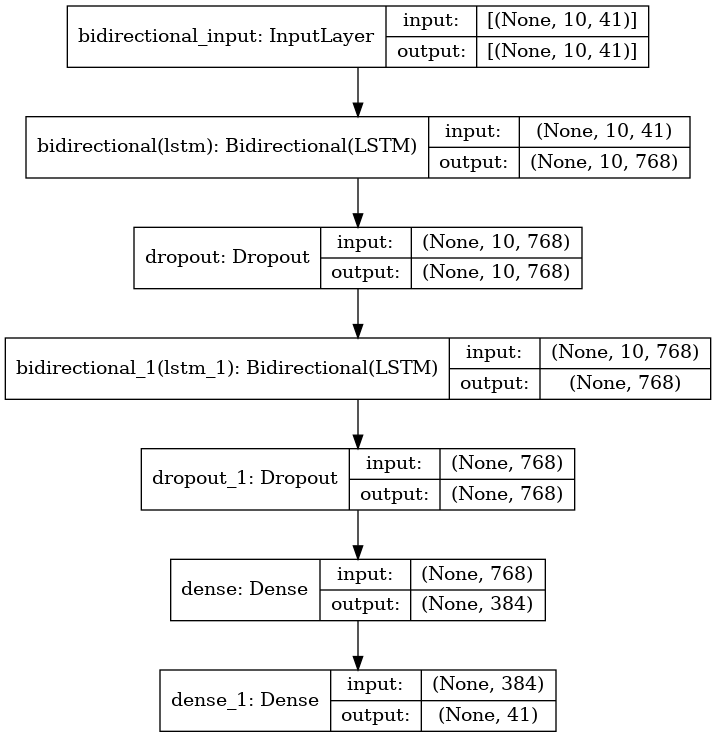

In [31]:
plot_model(best_model, to_file='/kaggle/working/char_language_modelling.png',show_shapes=True)

## Plotting loss and accuracy for training (Visualizing the training procedure)

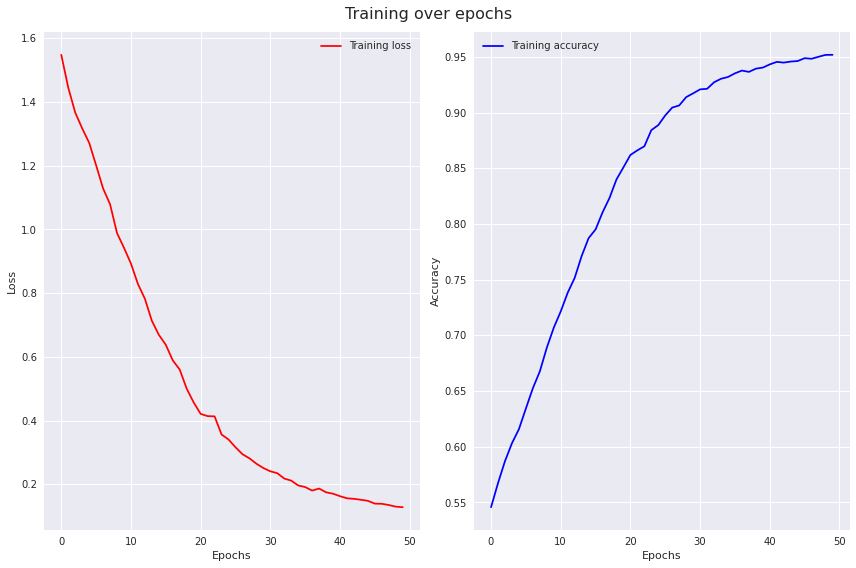

In [32]:
plt.style.use('seaborn')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))
fig.suptitle('Training over epochs', fontsize=16)

ax1.plot(history.history['loss'],color='red',label='Training loss')
ax1.legend()
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epochs')

ax2.plot(history.history['accuracy'],color='blue',label='Training accuracy')
ax2.legend()
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epochs')

plt.tight_layout()

## Saving the trained model

In [33]:
best_model.save('/kaggle/working/character_language_model.h5')

## Saving the mapping

In [34]:
## saving the mapping. We will need mapping to get the character from the predicted values
with open('/kaggle/working/mapping.pkl', 'wb') as f:
    pickle.dump(mapping, f)

## Loading the saved mapping and trained model

In [35]:
## Let's load a saved model and mapping to generate new text

model = load_model('/kaggle/working/character_language_model.h5')

with open('/kaggle/working/mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)

## Creating a function to load text generation using the trained model

### Approach

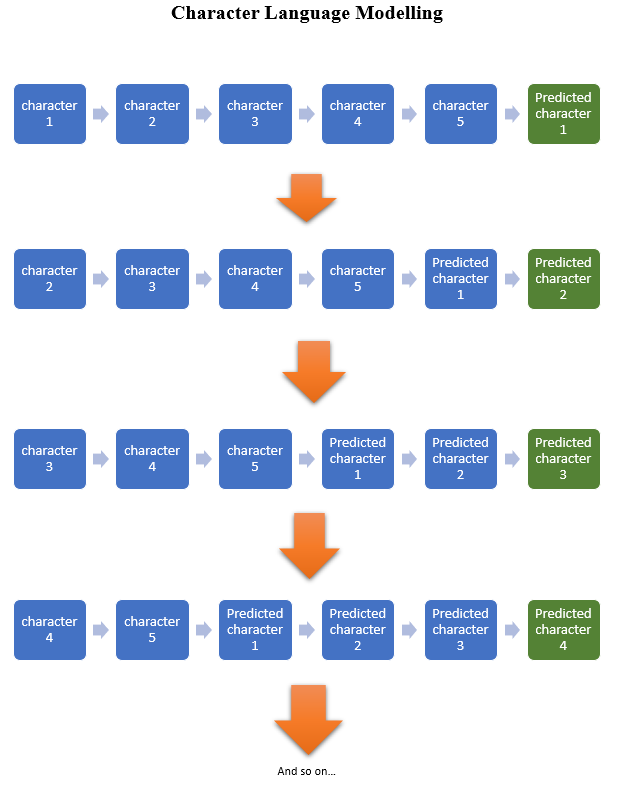

In [36]:
## we will predict the 11th character using the 10 given characters. Then we will add this 11th character to original sequence and then remove the first one.
## By repeating this, we can generate a sequence of characters making a word.

def generate_sequence(model, mapping, seq_length, input_text, num_char):
    in_text = input_text.lower()
    ## generating fixed number of characters
    for i in range(num_char):
        ## encode the input text into integers using mapping
        encoded_text =[mapping[character] for character in in_text]
        
        ## remove some of the initial characters to make the encoded_test of the size seq_length
        encoded_text = pad_sequences([encoded_text], maxlen=seq_length, truncating='pre')
        
        ## one-hot encoding
        encoded_text = to_categorical(encoded_text, num_classes=len(mapping))
        
        ## predicting the next character encoding
        yhat = np.argmax(model.predict(encoded_text), axis=-1)
        
        ## finding the character using the yhat and mapping
        output_char = ''
        for char, index in mapping.items():
            if index == yhat:
                output_char = char
                break
        
        ## appending the newly predicted input to the input text to create a new input text
        in_text  += output_char
    
    return in_text

## Generating the text using trained model

In [37]:
gen_text = generate_sequence(best_model, mapping, 10, "Dream a lo", 100)

In [38]:
gen_text

'dream a lonely little fisher-children snowballing each other in consternation. "she is lost in the snow, and h'